## What is sentiment analysis?

Sentiment analysis, also known as opinion mining, is a natural language processing (NLP) task that involves determining the emotional tone expressed in a piece of text. The primary goal of sentiment analysis is to classify the text into different categories based on the sentiment it conveys, such as positive, negative, or neutral. 

### Importing the modules

In [49]:
# Importing collections module for handling collections of data
import collections

# Importing datasets module for loading and processing datasets
import datasets

# Importing matplotlib.pyplot for plotting graphs and visualizations
import matplotlib.pyplot as plt

# Importing numpy for numerical operations and array manipulations
import numpy as np

# Importing torch for building and training neural networks
import torch

# Importing torch.nn for defining neural network layers and functions
import torch.nn as nn

# Importing torch.optim for optimization algorithms
import torch.optim as optim

import torchtext
from torchtext.vocab import build_vocab_from_iterator

# For tokenization
from torchtext.data import get_tokenizer

# Importing stopwords from nltk.corpus for removing common words that do not contribute to the sentiment
from nltk.corpus import stopwords

# Storing the stopwords in a set for faster lookup
stop_words = set(stopwords.words('english'))

# Importing tqdm for progress bar visualization
import tqdm

import string

print("Everything imported succesfully👍🏻")

Everything imported succesfully👍🏻


### Defining the parameters

In [62]:
test_size = 0.25
max_length = 256
min_freq = 5
batch_size = 512

### Loading the datasets

In [8]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

Generating unsupervised split: 100%|██████████| 50000/50000 [00:00<00:00, 105918.43 examples/s]


In [9]:
# Let's check the features in the data
print(train_data.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}


In [11]:
train_data[10]

{'text': 'It was great to see some of my favorite stars of 30 years ago including John Ritter, Ben Gazarra and Audrey Hepburn. They looked quite wonderful. But that was it. They were not given any characters or good lines to work with. I neither understood or cared what the characters were doing.<br /><br />Some of the smaller female roles were fine, Patty Henson and Colleen Camp were quite competent and confident in their small sidekick parts. They showed some talent and it is sad they didn\'t go on to star in more and better films. Sadly, I didn\'t think Dorothy Stratten got a chance to act in this her only important film role.<br /><br />The film appears to have some fans, and I was very open-minded when I started watching it. I am a big Peter Bogdanovich fan and I enjoyed his last movie, "Cat\'s Meow" and all his early ones from "Targets" to "Nickleodeon". So, it really surprised me that I was barely able to keep awake watching this one.<br /><br />It is ironic that this movie is a

### Data cleaning

#### Tokenization
tokenizer: the name of tokenizer function. If None, it returns split()
            function, which splits the string sentence by space.
            If basic_english, it returns _basic_english_normalize() function,
            which normalize the string first and split by space. If a callable
            function, it will return the function. If a tokenizer library
            (e.g. spacy, moses, toktok, revtok, subword), it returns the
            corresponding library.

In [19]:
# For tokenization
tokenizer = get_tokenizer("basic_english")

print(tokenizer("My name is Yuvraj Singh"))


['my', 'name', 'is', 'yuvraj', 'singh']


In [28]:
def tokenize_sentence(raw_text, tokenizer, max_length):
    """
    Tokenizes the input text using the specified tokenizer, removes stop words and punctuation, and truncates the tokens to the maximum length.

    Args:
        raw_text (dict): A dictionary containing the text to be tokenized with the key "text".
        tokenizer (callable): A tokenizer function that takes a string and returns a list of tokens.
        max_length (int): The maximum number of tokens to return.

    Returns:
        dict: A dictionary containing the truncated list of tokens with the key "tokens".
    """
    tokens = [token for token in tokenizer(raw_text["text"]) if token not in stop_words and token not in string.punctuation][:max_length]
    return {"tokens": tokens}

Each dataset provided by the datasets library is an instance of a Dataset class. We can see all the methods in a Dataset here, but the main one we are interested in is map. By using map we can apply a function to every example in the dataset and either update the example or create a new feature.

In [31]:
dummy_text = {
    "text": "Hello!!! This is a test sentence, with a lot of punctuation... and some stop words like 'the', 'is', 'at', 'which', and 'on'. Let's see how it works!"
}

tokenize_sentence(dummy_text, tokenizer,15)

{'tokens': ['hello',
  'test',
  'sentence',
  'lot',
  'punctuation',
  'stop',
  'words',
  'like',
  'let',
  'see',
  'works']}

In [32]:
train_data = train_data.map(
    tokenize_sentence, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_sentence, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

Map: 100%|██████████| 25000/25000 [00:09<00:00, 2538.05 examples/s]


In [33]:
train_data

Dataset({
    features: ['text', 'label', 'tokens'],
    num_rows: 25000
})

### Creation of validation set

Talk about the differnece between train,test and validation split

We can split a Dataset using the train_test_split method which splits a dataset into two, creating a DatasetDict for each split, one called train and another called test 

In [36]:
train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

25,000 training examples have now been split into 18,750 training examples and 6,250 validation examples, with the original 25,000 test examples remaining untouched.

In [37]:
len(train_data), len(valid_data), len(test_data)

(14062, 4688, 25000)

### Creating a Vocabulary

Next, we have to build a vocabulary. This is look-up table where every unique token in your dataset has a corresponding index (an integer).

We do this as machine learning models cannot operate on strings, only numerical vaslues. Each index is used to construct a one-hot vector for each token. A one-hot vector is a vector where all the elements are 0, except one, which is 1, and the dimensionality is the total number of unique tokens in your vocabulary, commonly denoted by 
.

For example:



One issue with creating a vocabulary using every single word in the dataset is that there are usually a considerable amount of unique tokens. One way to combat this is to either only construct the vocabulary only using the most commonly appearing tokens, or to only use tokens which appear a minimum amount of times in the dataset. In this notebook, we do the latter, keeping on the tokens which appear 5 times.

What happens to tokens which appear less than 5 times? We replace them with a special unknown token, denoted by <unk>. For example, if the sentence "This film is great and I love it", but the word "love" was not in the vocabulary, it would become: "This film is great and I <unk> it".

We use the build_vocab_from_iterator function from torchtext.vocab to create our vocabulary, specifying the min_freq (the minimum amount of times a token should appear to be added to the vocabulary) and special_tokens (tokens which should be appended to the start of the vocabulary, even if they don't appear min_freq times in the dataset).

The first special token is our unknown token, the other, <pad> is a special token we'll use for padding sentences.

When we feed sentences into our model, we pass a batch of sentences, i.e. more than one, at the same time. Passing a batch of sentences is preferred to passing sentences one at a time as it allows our model to perform computation on all sentences within a batch in paralle, thus speeding up the time taken to train and evaluate our model. All sentences within a batch need to be the same length (in terms of the number of tokens). Thus, to ensure each sentence is the same length, any shorter than the longest sentence need to have padding tokens appended to the end of them.

For an example batch of two sentences of length four and three tokens:

As we can see, the second sentence has been padded with a single <pad> token.

In [48]:
special_tokens = ["<unk>", "<pad>"]

vocab = build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [51]:
print("Length of vocabulary : ",len(vocab))
print("First 10 tokens in vocabulary : ",vocab.get_itos()[:10])

Length of vocabulary :  21734
First 10 tokens in vocabulary :  ['<unk>', '<pad>', 'movie', 'film', 'one', 'like', 'good', 'even', 'time', 'would']


We will be storing the indices of the unknown and padding tokens (zero and one, respectively) in variables, as we'll use these further.

In [52]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]
print("Index of <unk> : ",unk_index)
print("Index of <pad> : ",pad_index)

Index of <unk> :  0
Index of <pad> :  1


By default, a vocabulary created by torchtext will throw an error if you attempt to obtain the index of a token which is not in the vocabulary, i.e. vocab["some_token"] will throw an error.

We need to explicity tell the vocabulary which token to return if we pass a token not in the vocabulary. We do this using the set_default_index method, passing in the index we wish it to return. Here, we pass the index of the unknown token.

In [53]:
vocab.set_default_index(unk_index)

Now we have our vocabulary, we can numericalize our data. This involves converting the tokens within our dataset into indices. Similar to how we tokenized our data using the Dataset.map method, we'll define a function that takes an example and our vocabulary, gets the index for each token in each example and then creates an ids field which containes the numericalized tokens.

In [57]:
def numericalize_example(sentence, vocab):
    """
    Converts a list of tokens (sentence) into a list of corresponding indices using the provided vocabulary.

    Args:
        sentence (list of str): The input sentence represented as a list of tokens.
        vocab (Vocab): The vocabulary object used to convert tokens to indices.

    Returns:
        dict: A dictionary containing the numericalized tokens with the key 'ids'.
    """
    ids = vocab.lookup_indices(sentence["tokens"])
    return {"ids": ids}

# Apply the numericalize_example function to each example in the train and test datasets
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

# Display the updated train_data
train_data

Map: 100%|██████████| 25000/25000 [00:11<00:00, 2182.76 examples/s]


Dataset({
    features: ['text', 'label', 'tokens', 'ids'],
    num_rows: 14062
})

In [59]:
print(vocab.lookup_indices(train_data[0]["tokens"][:10]))
print(train_data[0]["ids"][:10])

[374, 171, 142, 2018, 857, 205, 451, 14750, 1424, 2474]
[374, 171, 142, 2018, 857, 205, 451, 14750, 1424, 2474]


The final step of is transforming the ids and label from integers into PyTorch tensors, which we do using the with_format method.

We do this because our PyTorch models work with tensors, and not integers.One thing to note is that when using with_format, all the columns not specified ("tokens" and "text") are removed from the example.

In [60]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

### Creating Data Loaders

The final step of preparing the data is creating the data loaders. We can iterate over a data loader to retrieve batches of examples. This is also where we will perform any padding that is necessary.

We first need to define a function to collate a batch, consisting of a list of examples, into what we want our data loader to output.

Here, our desired output from the data loader is a dictionary with keys of "ids" and "label".

The value of batch["ids"] should be a tensor of shape [batch size, length], where length is the length of the longest sentence (in terms of tokens) within the batch, and all sentences shorter than this should be padded to that length.

The value of batch["label"] should be a tensor of shape [batch size] consisting of the label for each sentence in the batch.

In [61]:
def create_collate_function(pad_index):
    """
    Creates a collate function for padding and batching sequences.

    Args:
        pad_index (int): The index used for padding in the sequences.

    Returns:
        function: A collate function that pads and batches sequences.
    """
    def collate_fn(batch):

        # Extract the 'ids' from each example in the batch
        batch_ids = [i["ids"] for i in batch]

        # Pad the sequences to the same length with the padding value
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )

        # Extract the 'label' from each example in the batch
        batch_label = [i["label"] for i in batch]

        # Stack the labels into a single tensor
        batch_label = torch.stack(batch_label)
        
        # Create a dictionary with the padded ids and labels
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [63]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = create_collate_function(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [64]:
train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

### Building the Model

In [75]:
class NBoW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.embedding(ids)
        # embedded = [batch size, seq len, embedding dim]
        pooled = embedded.mean(dim=1)
        # pooled = [batch size, embedding dim]
        prediction = self.fc(pooled)
        # prediction = [batch size, output dim]
        return prediction

In [76]:
vocab_size = len(vocab)
embedding_dim = 300
output_dim = len(train_data.unique("label"))

model = NBoW(vocab_size, embedding_dim, output_dim, pad_index)

In [67]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 6,520,802 trainable parameters


In [68]:
vectors = torchtext.vocab.GloVe()
hello_vector = vectors.get_vecs_by_tokens("hello")
hello_vector.shape
hello_vector[:32]

.vector_cache\glove.840B.300d.zip: 2.18GB [06:52, 5.28MB/s]                                
100%|█████████▉| 2196016/2196017 [09:08<00:00, 4005.61it/s]


tensor([ 0.2523,  0.1018, -0.6748,  0.2112,  0.4349,  0.1654,  0.4826, -0.8122,
         0.0413,  0.7850, -0.0779, -0.6632,  0.1464, -0.2929, -0.2549,  0.0193,
        -0.2026,  0.9823,  0.0283, -0.0813, -0.1214,  0.1313, -0.1765,  0.1356,
        -0.1636, -0.2257,  0.0550, -0.2031,  0.2072,  0.0958,  0.2248,  0.2154])

In [77]:
# Get the pretrained embeddings for the vocabulary tokens
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

# Print the shape of the pretrained embeddings tensor
print(pretrained_embedding.shape)

# Replace the model's embedding layer weights with the pretrained embeddings
model.embedding.weight.data = pretrained_embedding

torch.Size([21734, 300])


Why we replaced the model embedding layer weight with pretrained embeddings ? 

1. Leverage Pre-trained Knowledge:
Pre-trained embeddings like GloVe or Word2Vec capture semantic relationships between words based on large corpora. Using these embeddings can improve the model's performance, especially when the training data is limited.
2. Faster Convergence:
Initializing the embedding layer with pre-trained embeddings can lead to faster convergence during training because the model starts with a good approximation of word representations.
3. Better Generalization:
Pre-trained embeddings help the model generalize better to unseen data, as they provide a richer representation of words compared to random initialization.
By using pre-trained embeddings, the model benefits from the semantic information encoded in these embeddings, leading to potentially better performance in tasks like sentiment analysis.

In [78]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [79]:
model = model.to(device)
criterion = criterion.to(device)

In [80]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [81]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [82]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

### Initializing Training

In [83]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 10/10 [00:00<00:00, 16.73it/s]


epoch: 0
train_loss: 0.681, train_acc: 0.702
valid_loss: 0.668, valid_acc: 0.781


evaluating...: 100%|██████████| 10/10 [00:00<00:00, 21.80it/s]


epoch: 1
train_loss: 0.649, train_acc: 0.799
valid_loss: 0.633, valid_acc: 0.793


evaluating...: 100%|██████████| 10/10 [00:00<00:00, 20.58it/s]


epoch: 2
train_loss: 0.600, train_acc: 0.826
valid_loss: 0.584, valid_acc: 0.806


evaluating...: 100%|██████████| 10/10 [00:00<00:00, 10.85it/s]


epoch: 3
train_loss: 0.539, train_acc: 0.844
valid_loss: 0.530, valid_acc: 0.819


evaluating...: 100%|██████████| 10/10 [00:00<00:00, 10.04it/s]


epoch: 4
train_loss: 0.475, train_acc: 0.867
valid_loss: 0.480, valid_acc: 0.834


evaluating...: 100%|██████████| 10/10 [00:00<00:00, 14.82it/s]


epoch: 5
train_loss: 0.417, train_acc: 0.881
valid_loss: 0.439, valid_acc: 0.843


evaluating...: 100%|██████████| 10/10 [00:00<00:00, 20.55it/s]


epoch: 6
train_loss: 0.370, train_acc: 0.896
valid_loss: 0.406, valid_acc: 0.852


evaluating...: 100%|██████████| 10/10 [00:00<00:00, 18.92it/s]


epoch: 7
train_loss: 0.329, train_acc: 0.909
valid_loss: 0.380, valid_acc: 0.858


evaluating...: 100%|██████████| 10/10 [00:00<00:00, 14.94it/s]


epoch: 8
train_loss: 0.296, train_acc: 0.919
valid_loss: 0.361, valid_acc: 0.865


evaluating...: 100%|██████████| 10/10 [00:00<00:00, 17.74it/s]

epoch: 9
train_loss: 0.269, train_acc: 0.926
valid_loss: 0.346, valid_acc: 0.870


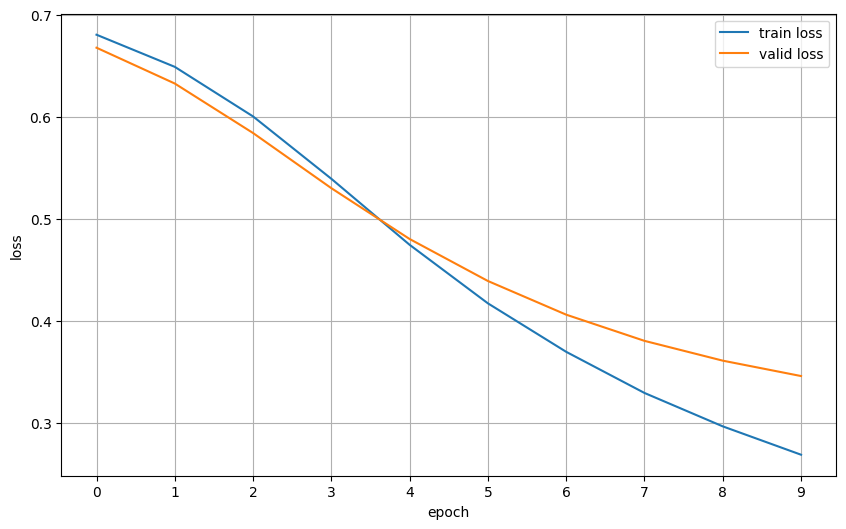

In [84]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

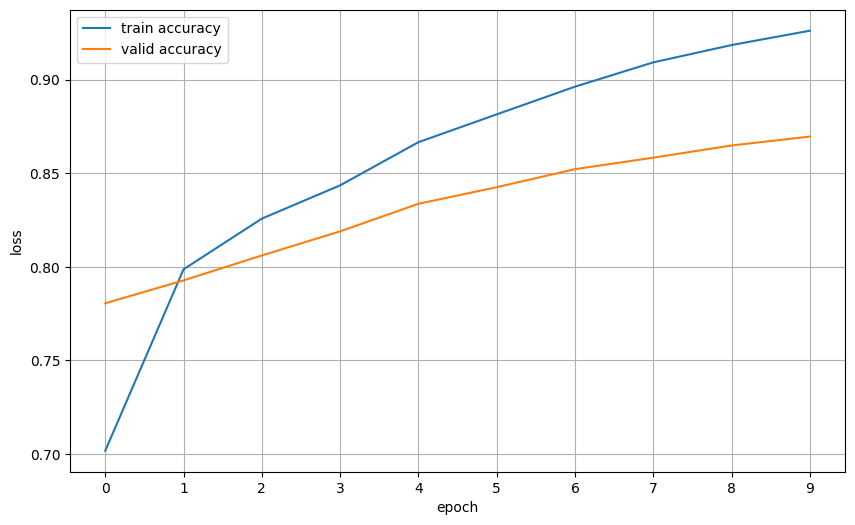

In [85]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [86]:
model.load_state_dict(torch.load("nbow.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 49/49 [00:04<00:00,  9.97it/s]


In [87]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.360, test_acc: 0.868


In [88]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [91]:
text = "I absolutely loved this movie! The storyline was captivating and the acting was superb."

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.8638931512832642)

In [94]:
text = "What a fantastic experience! The service was excellent and the food was delicious."

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.9969899654388428)

In [95]:
# Save the trained model
torch.save(model.state_dict(), "trained_neural_network.pt")

In [96]:
# Load the trained model
model.load_state_dict(torch.load("trained_neural_network.pt"))

text = "I absolutely loved this movie! The storyline was captivating and the acting was superb."

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.8638931512832642)